In [1]:
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp

np.seterr(all="ignore")

from threeML import *
from threeML.io.package_data import get_path_of_data_file
from threeML.io import update_logging_level
from threeML.utils.data_download.Fermi_LAT.download_LAT_data import LAT_dataset
from astropy.io import fits as pyfits

SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


# This if you want to toggle different type of logging level.
update_logging_level("INFO")
log.error("error")
log.info("info")
log.debug("debug")

19:25:16 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=477159;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=519473;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=336018;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=916319;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

19:25:17 WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=142704;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=2708;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

19:25:19 ERROR     error                                                                           ]8;id=701688;file:///var/folders/n8/w901w1rn4ldg6yskstndsj200000gn/T/ipykernel_48227/3699701126.py\3699701126.py]8;;\:]8;id=265242;file:///var/folders/n8/w901w1rn4ldg6yskstndsj200000gn/T/ipykernel_48227/3699701126.py#29\29]8;;\

         INFO      info                                                                            ]8;id=944087;file:///var/folders/n8/w901w1rn4ldg6yskstndsj200000gn/T/ipykernel_48227/3699701126.py\3699701126.py]8;;\:]8;id=445315;file:///var/folders/n8/w901w1rn4ldg6yskstndsj200000gn/T/ipykernel_48227/3699701126.py#30\30]8;;\

## GtBurst
Gtburst contains all the classes and methods to perform Fermi LAT data. It internally uses the official fermitools software. Here an example to list the IRFS available:


In [2]:
from GtBurst import IRFS

irfs = IRFS.IRFS.keys()
print(irfs)

odict_keys(['p7rep_transient', 'p7rep_source', 'p7rep_clean', 'p7rep_ultraclean', 'p8r2_transient100e', 'p8r2_transient100', 'p8r2_transient020e', 'p8r2_transient020', 'p8r2_transient010e', 'p8r2_transient010', 'p8r2_source', 'p8r2_clean', 'p8r2_ultraclean', 'p8r2_ultracleanveto', 'p8r2_transient100s', 'p8r2_transient015s', 'p8_transient100e', 'p8_transient100', 'p8_transient020e', 'p8_transient020', 'p8_transient010e', 'p8_transient010', 'p8_source', 'p8_clean', 'p8_ultraclean', 'p8_ultracleanveto', 'p8_sourceveto', 'p8_transient100s', 'p8_transient015s'])


## The LAT Transient Builder
Let's see how to make a plug in for the unbinned analysis of Fermi LAT data. First we use the information form a triggered GRB to obtain MET, RA and DEC, that are needed for the analysis.


In [3]:
from GtBurst.TriggerSelector import TriggerSelector

myFavoriteGRB = "bn190114873"


def findGRB(grb_name):
    a = TriggerSelector()
    a.downloadList()
    myGRB = {}
    for x in a.data:
        if x[0] == myFavoriteGRB:
            myGRB["MET"] = float(x[1])
            myGRB["RA"] = float(x[3])
            myGRB["DEC"] = float(x[4])
            myGRB["ERR"] = float(x[5])
            return myGRB
            pass
    return None

In [4]:
myGRB = findGRB(myFavoriteGRB)
print(myGRB)

{'MET': 569192227.626, 'RA': 54.51, 'DEC': -26.939, 'ERR': 0.05}


Then, we download LAT data and we build the transient builder, we want to analyze 1000 seconds since the trigger. Let's start download the data:


In [5]:
tstart = 0
tstop = 1000

In [6]:
myLATdataset = LAT_dataset()

myLATdataset.make_LAT_dataset(
    ra=myGRB["RA"],
    dec=myGRB["DEC"],
    radius=12,
    trigger_time=myGRB["MET"],
    tstart=tstart,
    tstop=tstop,
    data_type="Extended",
    destination_directory=".",
    Emin=100.0,
    Emax=10000.0,
)  # Energies are MeV (this is from 100 MeV to 10 GeV)

19:25:32 INFO      Query parameters:                                                       ]8;id=174320;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=922225;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#262\262]8;;\

         INFO                          coordfield = 54.5100,-26.9390                       ]8;id=739819;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=190517;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                         coordsystem = J2000                                  ]8;id=905550;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=513334;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                          shapefield = 12                                     ]8;id=92811;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=55531;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                           timefield = 569192227.626,569193227.626            ]8;id=989498;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=589675;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                            timetype = MET                                    ]8;id=779380;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=367980;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                         energyfield = 100.000,10000.000                      ]8;id=904979;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=452479;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO              photonOrExtendedOrNone = Extended                               ]8;id=555427;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=272276;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                         destination = query                                  ]8;id=760463;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=540066;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO                          spacecraft = checked                                ]8;id=883141;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=703544;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#266\266]8;;\

         INFO      Query ID: 86ad4d2b3b3e5065f0f0a976e6fc8315                              ]8;id=234555;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=572833;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#271\271]8;;\

19:25:34 INFO      Estimated complete time for your query: 15 seconds                      ]8;id=72920;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=222169;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#428\428]8;;\

         INFO      If this download fails, you can find your data at                       ]8;id=76689;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=72537;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#437\437]8;;\
                  https://fermi.gsfc.nasa.gov/cgi-bin/ssc/LAT/QueryResults.cgi?id=L2405201                         
                  52534DB968AF214 (when ready)                                                                     

19:25:40 INFO      Downloading FT1 and FT2 files...                                        ]8;id=414613;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=803206;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#527\527]8;;\

19:25:45 WARNING   Only one FT1 file provided. Skipping the merge...                        ]8;id=246842;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=624566;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#98\98]8;;\

Writing ./bn190114873/gll_cspec_tr_bn190114873_v00.rsp...
time -p gtselect infile=./bn190114873/gll_ft1_tr_bn190114873_v00.fit outfile=__temp_ft1.fits ra=54.51 dec=-26.939 rad=15.0 tmin=569192226.626 tmax=569193228.626 emin=10.0 emax=300000.0 zmin=0.0 zmax=110.0 evclass="INDEF" evtype="INDEF" convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
Done.
real 0.16
user 0.12
sys 0.03
Writing ./bn190114873/gll_cspec_tr_bn190114873_v00.pha...
 *  Get energy binning from the response matrix...

    done.

 *  Run gtbindef and gtbin and bin in energy and time...



time -p gtbindef bintype="E" binfile=__ebins.txt outfile=__energyBins.fits energyunits="keV" chatter=2 clobber=yes debug=no gui=no mode="ql"
This is gtbindef version HEAD
real 0.05
user 0.03
sys 0.01
time -p gtbin evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/__temp_ft1.fits scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit outfile=__gtllebin__pha2.pha algorithm="PHA2" ebinalg="FILE" emin=30.0 emax=200000.0 ebinfile=__energyBins.fits tbinalg="LIN" tstart=569192227.626 tstop=569193227.626 dtime=4.096 tbinfile=NONE coordsys="CEL" axisrot=0.0 rafield="RA" decfield="DEC" proj="AIT" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes hpx_region="" evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=1 clobber=yes debug=no gui=no mode="ql"
This is gtbin version HEAD


real 2.83
user 2.63
sys 0.19

    done.

 *  Transform gtbin output in CSPEC format...

    done.

 *  Updating keywords in the headers of the CSPEC file...

    done.

gtllebin done!


We want perform a time resolved analysis. So, first we look at the data. We can play with the ROI selection and the cut.


In [7]:
roi = 10
zmax = 110.0
thetamax = 180.0
irfs = "p8_transient020e"
strategy = "time"
myLATdataset.extract_events(roi, zmax, irfs, thetamax, strategy="time")

time -p gtmktime scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" filter="(DATA_QUAL>0 || DATA_QUAL==-1) && LAT_CONFIG==1 && IN_SAA!=T && LIVETIME>0 && (ANGSEP(RA_ZENITH,DEC_ZENITH,54.51,-26.939)<=(110.0-10))" roicut=no evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit evtable="EVENTS" outfile="gll_ft1_tr_bn190114873_v00_mkt.fit" apply_filter=yes overwrite=no header_obstimes=yes tstart=569192227.626 tstop=569193227.626 gtifile="default" chatter=2 clobber=yes debug=no gui=no mode="ql"
real 0.11
user 0.07
sys 0.02

Using 305 data

time -p gtselect infile=gll_ft1_tr_bn190114873_v00_mkt.fit outfile=gll_ft1_tr_bn190114873_v00_filt.fit ra=54.51 dec=-26.939 rad=10.0 tmin=569192227.626 tmax=569193227.626 emin=100.0 emax=10000.0 zmin=0.0 zmax=110.0 evclass=8 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=

Done.
real 0.13
user 0.10
sys 0.02

Selected 251 events.


19:25:48 INFO      Extracted 251 events                                                    ]8;id=136500;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py\download_LAT_data.py]8;;\:]8;id=629105;file:///Users/runner/work/threeML/threeML/threeML/utils/data_download/Fermi_LAT/download_LAT_data.py#670\670]8;;\

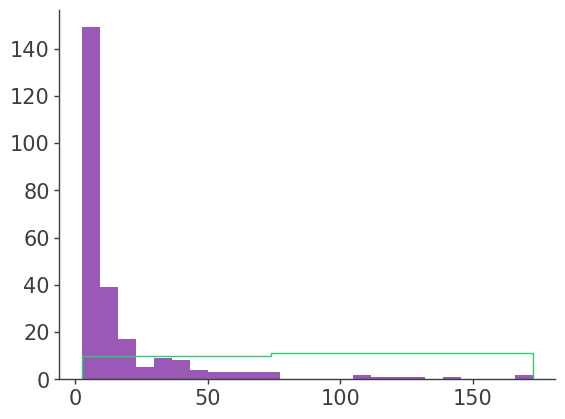

In [8]:
%matplotlib inline
event_file = pyfits.open(myLATdataset.filt_file)
event_times = sorted(event_file["EVENTS"].data["TIME"] - myGRB["MET"])
intervals = event_times[0::10]
_ = plt.hist(event_times)
_ = plt.hist(event_times, intervals, histtype="step")
# plt.show()

tstarts and tstops are defined as strings, with somma separated values for the starts and the ends of the time bins: For example tsrats="0,1,10" and tstops="1,10,20". To convert arrays in string we use these few lines of code:


In [9]:
tstarts = tstops = ""
for t0, t1 in zip(intervals[:-1], intervals[1:]):
    tstarts += "%.4f," % t0
    tstops += "%.4f," % t1
    pass
tstarts = tstarts[:-1].replace("-", "\\-")
tstops = tstops[:-1].replace("-", "\\-")

We can now make an instance the LAT transient builder


In [10]:
analysis_builder = TransientLATDataBuilder(
    myLATdataset.grb_name,
    outfile=myLATdataset.grb_name,
    roi=roi,
    tstarts=tstarts,
    tstops=tstops,
    irf=irfs,
    zmax=zmax,
    galactic_model="template",
    particle_model="isotr template",
    datarepository=".",
)
df = analysis_builder.display(get=True)

outfile                                                       190114873
roi                                                                  10
tstarts               2.6996,3.6358,3.9968,4.4024,4.7375,5.0909,5.54...
tstops                3.6358,3.9968,4.4024,4.7375,5.0909,5.5471,5.98...
zmax                                                              110.0
emin                                                              100.0
emax                                                           100000.0
irf                                                    p8_transient020e
galactic_model                                                 template
particle_model                                           isotr template
source_model                                                  PowerLaw2
tsmin                                                              20.0
strategy                                                           time
thetamax                                                        

In [11]:
tstops

'3.6358,3.9968,4.4024,4.7375,5.0909,5.5471,5.9896,6.3998,6.6889,7.0117,7.2936,7.7731,8.2167,8.8763,9.6573,10.5680,12.0568,14.6165,17.7834,21.4962,30.0798,40.8747,48.7118,73.7262,172.5754'

The run method will run (using gtburst) all the fermitools needed to obtain the needed file for the likelihood analysis (livetimecubes, exposure maps. It will also perfom a simple likelihood analysis with the standard likelihood of the fermitools (pylikelihood). The dataproducts created here will be used by threeML to make the fit.


In [12]:
LAT_observations = analysis_builder.run(include_previous_intervals=True)

19:25:49 INFO      Changing permission to                                              ]8;id=929324;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=580194;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#635\635]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/scripts/doTimeResolvedLike.py                                                      

         INFO      Changing permission to                                              ]8;id=379634;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=307823;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#635\635]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/gtapps_mp/gtdiffrsp_mp.py                                                          

         INFO      Changing permission to                                              ]8;id=588073;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=410405;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#635\635]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/gtapps_mp/gtexpmap_mp.py                                                           

         INFO      Changing permission to                                              ]8;id=909712;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=897850;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#635\635]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/gtapps_mp/gtltcube_mp.py                                                           

         INFO      Changing permission to                                              ]8;id=210139;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=124131;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#635\635]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/gtapps_mp/gttsmap_mp.py                                                            

         INFO      About to run the following command:                                 ]8;id=323108;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=570789;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#640\640]8;;\
                  /usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermi                             
                  tools/GtBurst/scripts/doTimeResolvedLike.py 190114873 --outfile                                  
                  '190114873' --roi 10.000000 --tstarts                                                            
                  '2.6996,3.6358,3.9968,4.4024,4.7375,5.0909,5.5471,5.9896,6.3998,6.68                             
                  89,7.0117,7.2936,7.7731,8.2167,8.8763,9.6573,10.5680,12.0568,14.6165                             
                  ,17.7834,21.4962,30.0798,40.8747,48.7118,73.7262' --tstops                                       
                  '3.6358,3.9968,4.4024,4.7375,5.0909,5.5471,5.9896,6.3998,6.6889,7.01                             
                  17,7.2936,7.7731,8.2167,8.8763,9.6573,10.5680,12.0568,14.6165,17.783                             
                  4,21.4962,30.0798,40.8747,48.7118,73.7262,172.5754' --zmax                                       
                  110.000000 --emin 100.000000 --emax 100000.000000 --irf                                          
                  'p8_transient020e' --galactic_model 'template' --particle_model                                  
                  'isotr template' --source_model 'PowerLaw2' --tsmin 20.000000                                    
                  --strategy 'time' --thetamax 180.000000 --spectralfiles 'no'                                     
                  --liketype 'unbinned' --optimizeposition 'no' --datarepository '.'                               
                  --ltcube '' --expomap '' --ulphindex -2.000000 --flemin 100.000000                               
                  --flemax 10000.000000 --fgl_mode 'fast'                                                          

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   25.19240     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .29E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

/usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/MPLPlot.py:54: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()
/usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/MPLPlot.py:65: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   13.71579     FROM MIGRAD    STATUS=CONVERGED     59 CALLS       60 TOTAL
                     EDM=   .58E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA


Requested intervals:
------------------------------------------------------
2.6996               - 3.6358
3.6358               - 3.9968
3.9968               - 4.4024
4.4024               - 4.7375
4.7375               - 5.0909
5.0909               - 5.5471
5.5471               - 5.9896
5.9896               - 6.3998
6.3998               - 6.6889
6.6889               - 7.0117
7.0117               - 7.2936
7.2936               - 7.7731
7.7731               - 8.2167
8.2167               - 8.8763
8.8763               - 9.6573
9.6573               - 10.568
10.568               - 12.0568
12.0568              - 14.6165
14.6165              - 17.7834
17.7834              - 21.4962
21.4962              - 30.0798
30.0798              - 40.8747
40.8747              - 48.7118
48.7118              - 73.7262
73.7262              - 172.5754

Data files:
-----------
eventfile            /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit
ft2file      

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   4.786573     FROM MIGRAD    STATUS=CONVERGED     59 CALLS       60 TOTAL
                     EDM=   .14E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   5.901543     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .70E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

time -p gtdiffrsp evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval3.6358-3.9968/gll_ft1_tr_bn190114873_v00_filt.fit evtable="EVENTS" scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" srcmdl=190114873_LAT_xmlmodel_3.6358-3.9968.xml irfs="P8R3_TRANSIENT020E_V3" evclsmin="INDEF" evclass="INDEF" evtype="INDEF" convert=no chatter=2 clobber=yes debug=no gui=no mode="ql"
adding source 4FGL J0322.6-3712e
adding source GalacticTemplate
adding source IsotropicTemplate
Working on...
/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval3.6358-3.9968/gll_ft1_tr_bn190114873_v00_filt.fit..........!
real 6.85
user 6.31
sys 0.53
Loading python Likelihood interface...

Applying a Gaussian prior with sigma 0.15 on the normalization of the Galactic Template
{'Norm': 1.0, 'Mean': 1.0, 'Sigma': 0.15, 'Offset': 0.0}

Likelihood settings:

Event file(s): /Users/runner/work/threeML/threeML

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   13.43105     FROM MIGRAD    STATUS=CONVERGED     67 CALLS       68 TOTAL
                     EDM=   .19E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

Total time in Good Time Intervals:        0.3350999355316162
-> gtbuildxmlmodel xmlmodel='190114873_LAT_xmlmodel_4.4024-4.7375.xml' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' galactic_model='template' particle_model='isotr template' ra='54.51' dec='-26.939' fgl_mode='fast' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' source_model='PowerLaw2'

Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 

addFGLsources( 54.51 -26.939 18.0 190114873_LAT_xmlmodel_4.4024-4.7375.xml 0.3350999355316162 )
('SpatialMap', True)
Keeping diffuse source 4FGL J0322.6-3712e (10.77 deg away) using template /usr/local/miniconda/envs

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   11.37565     FROM MIGRAD    STATUS=CONVERGED     74 CALLS       75 TOTAL
                     EDM=   .16E-05  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  9.4%

  EXT PARAMETER                            

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   7.632503     FROM MIGRAD    STATUS=CONVERGED     61 CALLS       62 TOTAL
                     EDM=   .99E-06  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  5.3%

  EXT PARAMETER                            

|--------------------|---------------|----------|  ----------|----------|------|
|         Source name|      Par. Name|     Value|       Error|     Units|    TS|
|--------------------|---------------|----------|------------|----------|------|
|GRB                 |               |          |            |          |   145|
|                    |       Integral|    0.0202|     0.00667| ph./cm2/s|      |
|                    |          Index|     -2.16|       0.362|         -|      |
|                    |     LowerLimit|       100|n.a. (fixed)|       MeV|      |
|                    |     UpperLimit|     1e+05|n.a. (fixed)|       MeV|      |
|                    |    Energy flux|  1.23e-05|    5.57e-06| erg/cm2/s|      |
|                    |    Photon flux|    0.0201|     0.00668| ph./cm2/s|      |
|GalacticTemplate    |               |          |            |          |     0|
|                    |          Value|         1|        0.15|         -|      |
|                    |    En

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   10.79486     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .15E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   6.844639     FROM MIGRAD    STATUS=CONVERGED     66 CALLS       67 TOTAL
                     EDM=   .31E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

-> gtdolike.py spectralfiles='no' xmlmodel='190114873_LAT_xmlmodel_5.5471-5.9896.xml' liketype='unbinned' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' showmodelimage='no' tsmin='20.0' optimizeposition='no' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' skymap='190114873_LAT_skymap_5.5471-5.9896.fit' flemin='100.000000' flemax='10000.000000'
time -p gtltcube evfile="/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval5.5471-5.9896/gll_ft1_tr_bn190114873_v00_filt.fit" evtable="EVENTS" scfile=__ft2temp.fits sctable="SC_DATA" outfile=gll_ft1_tr_bn190114873_v00_filt_ltcube.fit dcostheta=0.025 binsz=1.0 phibins=1 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=180.0 chatter=2 clobber=yes debug=no gui=no mode="ql"
Working on file __ft2temp.fits
..!
real 0.65
user 0.32
sys 0.30
/usr/lo

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   8.317516     FROM MIGRAD    STATUS=CONVERGED     55 CALLS       56 TOTAL
                     EDM=   .68E-04    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

-> gtdocountsmap.py rad='10.0' eventfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit' zmax='110.0' thetamax='180.0' emin='100.0' emax='100000.0' skymap='190114873_LAT_skymap_6.3998-6.6889.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' strategy='time' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' tstart='6.3998' tstop='6.6889' ra='54.51' dec='-26.939' irf='p8_transient020e' allowEmpty='no'
time -p gtmktime scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" filter="(DATA_QUAL>0 || DATA_QUAL==-1) && LAT_CONFIG==1 && IN_SAA!=T && LIVETIME>0 && (ANGSEP(RA_ZENITH,DEC_ZENITH,54.51,-26.939)<=(110.0-10.0))" roicut=no evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   12.58093     FROM MIGRAD    STATUS=CONVERGED     62 CALLS       63 TOTAL
                     EDM=   .10E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

/usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/fermitools/MPLPlot.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure()


 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   18.30164     FROM MIGRAD    STATUS=CONVERGED     68 CALLS       69 TOTAL
                     EDM=   .14E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

adding source 4FGL J0322.6-3712e
adding source GalacticTemplate
adding source IsotropicTemplate
Working on...
/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval6.6889-7.0117/gll_ft1_tr_bn190114873_v00_filt.fit.........!
real 6.66
user 6.13
sys 0.52
Loading python Likelihood interface...

Applying a Gaussian prior with sigma 0.15 on the normalization of the Galactic Template
{'Norm': 1.0, 'Mean': 1.0, 'Sigma': 0.15, 'Offset': 0.0}

Likelihood settings:

Event file(s): /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval6.6889-7.0117/gll_ft1_tr_bn190114873_v00_filt.fit
Spacecraft file(s): /Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit
Exposure map: gll_ft1_tr_bn190114873_v00_filt_expomap.fit
Exposure cube: gll_ft1_tr_bn190114873_v00_filt_ltcube.fit
IRFs: P8R3_TRANSIENT020E_V3
Source model file: 190114873_LAT_xmlmodel_6.6889-7.0117.xml
Optimizer: Minuit

Performing likelihood fit...
Data  9.0
srcN

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   14.90094     FROM MIGRAD    STATUS=CONVERGED     59 CALLS       60 TOTAL
                     EDM=   .44E-04    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

-> gtbuildxmlmodel xmlmodel='190114873_LAT_xmlmodel_7.2936-7.7731.xml' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' galactic_model='template' particle_model='isotr template' ra='54.51' dec='-26.939' fgl_mode='fast' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' source_model='PowerLaw2'

Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 

addFGLsources( 54.51 -26.939 18.0 190114873_LAT_xmlmodel_7.2936-7.7731.xml 0.47950005531311035 )
('SpatialMap', True)
Keeping diffuse source 4FGL J0322.6-3712e (10.77 deg away) using template /usr/local/miniconda/envs/test_env/share/fermitools/data/pyBurstAnalysisGUI/templates

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   13.18701     FROM MIGRAD    STATUS=CONVERGED     62 CALLS       63 TOTAL
                     EDM=   .24E-05  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  6.5%

  EXT PARAMETER                            

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   24.59086     FROM MIGRAD    STATUS=CONVERGED     57 CALLS       58 TOTAL
                     EDM=   .13E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

|--------------------|---------------|----------|  ----------|----------|------|
|         Source name|      Par. Name|     Value|       Error|     Units|    TS|
|--------------------|---------------|----------|------------|----------|------|
|GRB                 |               |          |            |          |   128|
|                    |       Integral|     0.018|     0.00597| ph./cm2/s|      |
|                    |          Index|     -2.62|       0.447|         -|      |
|                    |     LowerLimit|       100|n.a. (fixed)|       MeV|      |
|                    |     UpperLimit|     1e+05|n.a. (fixed)|       MeV|      |
|                    |    Energy flux|  7.11e-06|    2.74e-06| erg/cm2/s|      |
|                    |    Photon flux|     0.018|     0.00597| ph./cm2/s|      |
|GalacticTemplate    |               |          |            |          |     1|
|                    |          Value|         1|       0.134|         -|      |
|                    |    En

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   28.24928     FROM MIGRAD    STATUS=CONVERGED     56 CALLS       57 TOTAL
                     EDM=   .18E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   29.59265     FROM MIGRAD    STATUS=CONVERGED     73 CALLS       74 TOTAL
                     EDM=   .12E-02    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

-> gtdolike.py spectralfiles='no' xmlmodel='190114873_LAT_xmlmodel_8.8763-9.6573.xml' liketype='unbinned' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' showmodelimage='no' tsmin='20.0' optimizeposition='no' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' skymap='190114873_LAT_skymap_8.8763-9.6573.fit' flemin='100.000000' flemax='10000.000000'
time -p gtltcube evfile="/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval8.8763-9.6573/gll_ft1_tr_bn190114873_v00_filt.fit" evtable="EVENTS" scfile=__ft2temp.fits sctable="SC_DATA" outfile=gll_ft1_tr_bn190114873_v00_filt_ltcube.fit dcostheta=0.025 binsz=1.0 phibins=1 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=180.0 chatter=2 clobber=yes debug=no gui=no mode="ql"
Working on file __ft2temp.fits
..!
real 0.63
user 0.32
sys 0.29
/usr/lo

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   30.55516     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .11E-04  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  6.1%

  EXT PARAMETER                            

-> gtdocountsmap.py rad='10.0' eventfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit' zmax='110.0' thetamax='180.0' emin='100.0' emax='100000.0' skymap='190114873_LAT_skymap_10.568-12.0568.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' strategy='time' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' tstart='10.568' tstop='12.0568' ra='54.51' dec='-26.939' irf='p8_transient020e' allowEmpty='no'
time -p gtmktime scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" filter="(DATA_QUAL>0 || DATA_QUAL==-1) && LAT_CONFIG==1 && IN_SAA!=T && LIVETIME>0 && (ANGSEP(RA_ZENITH,DEC_ZENITH,54.51,-26.939)<=(110.0-10.0))" roicut=no evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn19011487

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   29.31981     FROM MIGRAD    STATUS=CONVERGED     55 CALLS       56 TOTAL
                     EDM=   .64E-05  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  3.9%

  EXT PARAMETER                            

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 MIGRAD MINIMIZATION HAS CONVERGED.

 FCN=   38.58473     FROM MIGRAD    STATUS=CONVERGED     60 CALLS       61 TOTAL
                     EDM=   .91E-05  STRATEGY=1  ERROR MATRIX UNCERTAINTY=  4.2%

  EXT PARAMETER                            

time -p gtdiffrsp evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval12.0568-14.6165/gll_ft1_tr_bn190114873_v00_filt.fit evtable="EVENTS" scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" srcmdl=190114873_LAT_xmlmodel_12.0568-14.6165.xml irfs="P8R3_TRANSIENT020E_V3" evclsmin="INDEF" evclass="INDEF" evtype="INDEF" convert=no chatter=2 clobber=yes debug=no gui=no mode="ql"
adding source 4FGL J0322.6-3712e
adding source GalacticTemplate
adding source IsotropicTemplate
Working on...
/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval12.0568-14.6165/gll_ft1_tr_bn190114873_v00_filt.fit.........!
real 6.74
user 6.20
sys 0.53
Loading python Likelihood interface...

Applying a Gaussian prior with sigma 0.15 on the normalization of the Galactic Template
{'Norm': 1.0, 'Mean': 1.0, 'Sigma': 0.15, 'Offset': 0.0}

Likelihood settings:

Event file(s): /Users/runner/work/threeML/th

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   41.85635     FROM MIGRAD    STATUS=CONVERGED     68 CALLS       69 TOTAL
                     EDM=   .15E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

time -p gtbin evfile=gll_ft1_tr_bn190114873_v00_filt.fit scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit outfile=190114873_LAT_skymap_17.7834-21.4962.fit algorithm="CMAP" ebinalg="LOG" emin=30.0 emax=200000.0 ebinfile=NONE tbinalg="LIN" tbinfile=NONE nxpix=101 nypix=101 binsz=0.2 coordsys="CEL" xref=54.51 yref=-26.939 axisrot=0.0 rafield="RA" decfield="DEC" proj="AIT" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes hpx_region="" evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=2 clobber=yes debug=no gui=no mode="ql"
This is gtbin version HEAD
real 0.23
user 0.14
sys 0.02

Total number of events in the counts map: 11
Total time in Good Time Intervals:        3.712799906730652
-> gtbuildxmlmodel xmlmodel='190114873_LAT_xmlmodel_17.7834-21.4962.xml' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' galactic_model='template' particle_model='isotr template' ra='54.51' dec='-26.939' fgl_mode='fas

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   40.63160     FROM MIGRAD    STATUS=CONVERGED     71 CALLS       72 TOTAL
                     EDM=   .94E-04    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   34.58971     FROM MIGRAD    STATUS=CONVERGED     73 CALLS       74 TOTAL
                     EDM=   .11E-04    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

|--------------------|---------------|----------|  ----------|----------|------|
|         Source name|      Par. Name|     Value|       Error|     Units|    TS|
|--------------------|---------------|----------|------------|----------|------|
|GRB                 |               |          |            |          |   119|
|                    |       Integral|  0.000725|     0.00023| ph./cm2/s|      |
|                    |          Index|     -1.42|       0.272|         -|      |
|                    |     LowerLimit|       100|n.a. (fixed)|       MeV|      |
|                    |     UpperLimit|     1e+05|n.a. (fixed)|       MeV|      |
|                    |    Energy flux|   1.2e-06|    5.71e-07| erg/cm2/s|      |
|                    |    Photon flux|  0.000656|    0.000215| ph./cm2/s|      |
|GalacticTemplate    |               |          |            |          |     0|
|                    |          Value|         1|        0.15|         -|      |
|                    |    En

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   51.56070     FROM MIGRAD    STATUS=CONVERGED     59 CALLS       60 TOTAL
                     EDM=   .14E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

 **********
 **    1 **SET PRINT     .000    
 **********
 **********
 **    2 **SET NOWARN 
 **********

 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 'Integral  '    .10000E-01   1.0000         .10000E-04   1000.0    
     2 'Index     '   -2.0000       1.0000        -6.0000       .10000E-01
     3 'Value     '    1.0000       1.0000         .70000       1.3000    
     4 'Normalizat'    1.0000       1.0000         .10000       10.000    
 **********
 **    3 **SET ERR    .5000    
 **********
 **********
 **    4 **SET GRAD    1.000    
 **********
 **********
 **    5 **MINIMIZE    900.0       2.000    
 **********

 MIGRAD MINIMIZATION HAS CONVERGED.

 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.

 FCN=   66.71287     FROM MIGRAD    STATUS=CONVERGED     64 CALLS       65 TOTAL
                     EDM=   .42E-03    STRATEGY= 1      ERROR MATRIX ACCURATE 

  EXT PARAMETER                                   STEP         FIRST   
  NO.   NA

-> gtdolike.py spectralfiles='no' xmlmodel='190114873_LAT_xmlmodel_40.8747-48.7118.xml' liketype='unbinned' filteredeventfile='gll_ft1_tr_bn190114873_v00_filt.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' showmodelimage='no' tsmin='20.0' optimizeposition='no' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' skymap='190114873_LAT_skymap_40.8747-48.7118.fit' flemin='100.000000' flemax='10000.000000'
time -p gtltcube evfile="/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/interval40.8747-48.7118/gll_ft1_tr_bn190114873_v00_filt.fit" evtable="EVENTS" scfile=__ft2temp.fits sctable="SC_DATA" outfile=gll_ft1_tr_bn190114873_v00_filt_ltcube.fit dcostheta=0.025 binsz=1.0 phibins=1 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=180.0 chatter=2 clobber=yes debug=no gui=no mode="ql"
Working on file __ft2temp.fits
..!
real 0.65
user 0.32
sys 0.31
/

-> gtdocountsmap.py rad='10.0' eventfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn190114873_v00.fit' zmax='110.0' thetamax='180.0' emin='100.0' emax='100000.0' skymap='190114873_LAT_skymap_73.7262-172.5754.fit' rspfile='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_cspec_tr_bn190114873_v00.rsp' strategy='time' ft2file='/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit' tstart='73.7262' tstop='172.5754' ra='54.51' dec='-26.939' irf='p8_transient020e' allowEmpty='no'
time -p gtmktime scfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft2_tr_bn190114873_v00.fit sctable="SC_DATA" filter="(DATA_QUAL>0 || DATA_QUAL==-1) && LAT_CONFIG==1 && IN_SAA!=T && LIVETIME>0 && (ANGSEP(RA_ZENITH,DEC_ZENITH,54.51,-26.939)<=(110.0-10.0))" roicut=no evfile=/Users/runner/work/threeML/threeML/docs/md_docs/slow_execute/bn190114873/gll_ft1_tr_bn1901

19:37:53 INFO      The ft2 file does not exist. Please examine!                        ]8;id=818768;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=823552;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=774998;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=81530;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=390794;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=797467;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval10.568-12.0568/gll_ft2_tr_bn190114873_v00.fit                                            

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=541482;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=244563;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=127526;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=140158;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=256496;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=915994;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval12.0568-14.6165/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=124283;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=270555;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=327478;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=343610;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=891038;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=624457;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval14.6165-17.7834/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=786050;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=513779;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=377232;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=324419;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=403049;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=876021;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval17.7834-21.4962/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=348633;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=929180;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=922313;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=159522;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=594112;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=399097;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval2.6996-3.6358/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=562567;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=260541;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=656327;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=34799;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=961195;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=565098;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval21.4962-30.0798/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=322777;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=131094;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=980241;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=612568;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=848252;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=908682;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval3.6358-3.9968/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=904761;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=665080;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=553064;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=531463;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=543989;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=773228;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval3.9968-4.4024/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=910364;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=686441;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=901114;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=594924;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=619932;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=866327;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval30.0798-40.8747/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=380097;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=132082;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=962565;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=238401;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=666621;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=2898;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval4.4024-4.7375/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=337066;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=195304;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=248471;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=268963;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=670813;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=624118;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval4.7375-5.0909/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=445752;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=921930;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=170092;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=997430;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=889546;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=447478;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval40.8747-48.7118/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=589363;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=323746;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=786453;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=351609;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=332627;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=384897;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval48.7118-73.7262/gll_ft2_tr_bn190114873_v00.fit                                           

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=417393;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=598396;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=772080;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=838946;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=868642;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=407847;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval5.0909-5.5471/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=765744;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=27378;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=344240;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=485032;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=351137;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=376606;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval5.5471-5.9896/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=719179;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=299537;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=59343;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=268551;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=732590;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=955914;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval5.9896-6.3998/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=610618;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=651183;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

19:37:54 INFO      we will grab the data file for you.                                 ]8;id=448847;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=865346;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=874615;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=850397;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval6.3998-6.6889/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=507818;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=117285;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=372489;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=448393;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=726965;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=669465;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval6.6889-7.0117/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=366578;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=737271;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=414069;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=284437;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=430856;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=55476;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval7.0117-7.2936/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=471855;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=467512;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=221822;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=283498;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=110189;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=880694;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval7.2936-7.7731/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=88730;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=404007;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=873068;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=273032;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=795646;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=451441;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval7.7731-8.2167/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=300884;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=537756;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=493433;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=67381;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=930371;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=148657;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval73.7262-172.5754/gll_ft2_tr_bn190114873_v00.fit                                          

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=846494;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=978246;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=512071;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=25083;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=954466;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=185766;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval8.2167-8.8763/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=637422;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=125335;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=89049;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=495469;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=507853;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=916670;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval8.8763-9.6573/gll_ft2_tr_bn190114873_v00.fit                                             

         INFO      The ft2 file does not exist. Please examine!                        ]8;id=704713;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=188763;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#726\726]8;;\

         INFO      we will grab the data file for you.                                 ]8;id=825534;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=231078;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#727\727]8;;\

         INFO      copied ./bn190114873/gll_ft2_tr_bn190114873_v00.fit to              ]8;id=259586;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=360241;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#743\743]8;;\
                  interval9.6573-10.568/gll_ft2_tr_bn190114873_v00.fit                                             

 At this point we can create the FermiLATLike plugins from each of the observation:

In [13]:
LAT_plugins = {}
for l in LAT_observations:
    LAT_name = "LAT_%06.3f-%06.3f" % (float(l.tstart), float(l.tstop))
    LAT_plugins[LAT_name] = l.to_LATLike()
    pass

FermiLATLike - GTI SUM =  1.488800048828125
FermiLATLike - GTI SUM =  2.5597000122070312
FermiLATLike - GTI SUM =  3.1669000387191772


FermiLATLike - GTI SUM =  3.712799906730652
FermiLATLike - GTI SUM =  0.9362000226974487


FermiLATLike - GTI SUM =  8.583600044250488
FermiLATLike - GTI SUM =  0.3609999418258667


FermiLATLike - GTI SUM =  0.40560007095336914


FermiLATLike - GTI SUM =  10.794899940490723
FermiLATLike - GTI SUM =  0.3350999355316162


FermiLATLike - GTI SUM =  0.35339999198913574
FermiLATLike - GTI SUM =  7.837100028991699


FermiLATLike - GTI SUM =  25.014400005340576
FermiLATLike - GTI SUM =  0.4562000036239624


FermiLATLike - GTI SUM =  0.4424999952316284


FermiLATLike - GTI SUM =  0.41019999980926514
FermiLATLike - GTI SUM =  0.2891000509262085


FermiLATLike - GTI SUM =  0.32280004024505615
FermiLATLike - GTI SUM =  0.28189992904663086


FermiLATLike - GTI SUM =  0.47950005531311035


FermiLATLike - GTI SUM =  0.4435999393463135


FermiLATLike - GTI SUM =  98.84920001029968


FermiLATLike - GTI SUM =  0.659600019454956
FermiLATLike - GTI SUM =  0.781000018119812


FermiLATLike - GTI SUM =  0.9106999635696411


For reference, these are the keys save in the dictionary.


In [14]:
LAT_plugins.keys()

dict_keys(['LAT_10.568-12.057', 'LAT_12.057-14.617', 'LAT_14.617-17.783', 'LAT_17.783-21.496', 'LAT_02.700-03.636', 'LAT_21.496-30.080', 'LAT_03.636-03.997', 'LAT_03.997-04.402', 'LAT_30.080-40.875', 'LAT_04.402-04.737', 'LAT_04.737-05.091', 'LAT_40.875-48.712', 'LAT_48.712-73.726', 'LAT_05.091-05.547', 'LAT_05.547-05.990', 'LAT_05.990-06.400', 'LAT_06.400-06.689', 'LAT_06.689-07.012', 'LAT_07.012-07.294', 'LAT_07.294-07.773', 'LAT_07.773-08.217', 'LAT_73.726-172.575', 'LAT_08.217-08.876', 'LAT_08.876-09.657', 'LAT_09.657-10.568'])

Now we can perform the fit in each bin. Note that we set the model, and we set some initial values. All the resulting joint likelihood objects are stored in a dictioonary to be used later for plotting.


In [15]:
results = {}
update_logging_level("DEBUG")

for T0, T1 in zip(intervals[:-1], intervals[1:]):
    GRB = PointSource(
        "GRB", ra=myGRB["RA"], dec=myGRB["DEC"], spectral_shape=Powerlaw_flux()
    )
    model = Model(GRB)
    model.GRB.spectrum.main.Powerlaw_flux.a = 100.0 * u.MeV
    model.GRB.spectrum.main.Powerlaw_flux.b = 10000.0 * u.MeV
    model.GRB.spectrum.main.Powerlaw_flux.F = 1.0
    LAT_name = "LAT_%06.3f-%06.3f" % (T0, T1)
    LAT_model_name = ("LAT%dX%d" % (T0, T1)).replace("-", "n")
    datalist = DataList(LAT_plugins[LAT_name])
    model["GRB.spectrum.main.Powerlaw_flux.F"].bounds = (1e-6, 1e6)
    model["GRB.spectrum.main.Powerlaw_flux.F"].value = 1e-2
    model["GRB.spectrum.main.Powerlaw_flux.index"].value = -2.2
    model["GRB.spectrum.main.Powerlaw_flux.index"].bounds = (-3, 0)
    jl = JointLikelihood(model, datalist, verbose=False)
    model[LAT_model_name + "_GalacticTemplate_Value"].value = 1.0
    model[LAT_model_name + "_GalacticTemplate_Value"].fix = True
    model[LAT_model_name + "_GalacticTemplate_Value"].fix = True
    # model.display( complete=True )
    jl.set_minimizer("minuit")
    jl.fit(compute_covariance=True)
    results[LAT_name] = jl
    pass

19:38:02 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=36842;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=675503;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

19:38:02 DEBUG     creating new MLE analysis                                                 ]8;id=37516;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=231467;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=231345;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=55458;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:38:10 DEBUG     Removing non-needed files                                                    ]8;id=425953;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=685095;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=656584;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=525843;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=813529;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=981789;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=124489;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=818435;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=755103;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=542814;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=465579;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=372018;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=73042;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=883974;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=129697;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=558454;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=828873;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=385023;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=364608;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=763996;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.035850408347845                       ]8;id=31936;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=210494;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.999991708177062                   ]8;id=572433;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=562151;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT2X3_IsotropicTemplate_Normalization = 4.9998262064715675                  ]8;id=620287;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=137464;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=471138;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=208507;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   75.56 percent of samples have been thrown away because they failed the  ]8;id=501276;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=761425;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(9.2 -2.5 +3.4) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-3.0000 +/- 0.0033,
LAT2X3_IsotropicTemplate_Normalization,5.0 +/- 0.4,


Correlation matrix:

1.00,-0.00,-0.00
-0.00,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT2X3,40.664992
total,40.664992


Values of statistical measures:

,statistical measures
AIC,91.329983
BIC,88.237739


19:38:10 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=150474;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=284503;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=195794;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=381396;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=198037;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=787289;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:38:17 DEBUG     Removing non-needed files                                                    ]8;id=322524;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=784871;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=699058;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=851881;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=617291;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=700544;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=584045;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=802759;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=330588;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=84735;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=329901;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=377264;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=506439;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=994720;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=694069;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=93959;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=676765;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=122441;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=144564;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=208666;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6218053649739153                      ]8;id=565256;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=411699;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.9999932121176722                  ]8;id=150993;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=376724;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT3X3_IsotropicTemplate_Normalization = 4.997384151781968                   ]8;id=769241;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=582130;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=810227;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=926415;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   74.62 percent of samples have been thrown away because they failed the  ]8;id=421848;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=206832;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.4 -0.6 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-3.0000 +/- 0.0026,
LAT3X3_IsotropicTemplate_Normalization,5.0 +/- 1.5,


Correlation matrix:

1.00,-0.00,-0.00
-0.00,1.00,-0.00
-0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT3X3,29.516899
total,29.516899


Values of statistical measures:

,statistical measures
AIC,69.033798
BIC,65.941553


19:38:17 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=972585;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=85060;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=858680;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=331940;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=520768;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=812847;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:38:25 DEBUG     Removing non-needed files                                                    ]8;id=944687;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=683122;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=739275;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=857484;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=960884;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=944804;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=738146;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=348522;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=33589;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=948616;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=944470;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=222823;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=674492;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=106954;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=433317;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=219893;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=718637;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=897347;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=227329;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=754277;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6739857264716593                      ]8;id=179208;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=335322;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.9704822069906327                  ]8;id=223221;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=391487;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT3X4_IsotropicTemplate_Normalization = 0.10022644625362875                 ]8;id=785794;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=279545;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=229313;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=712429;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   73.54 percent of samples have been thrown away because they failed the  ]8;id=297268;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=615593;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.1 -0.6 +0.8) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-3.0 +/- 0.5,
LAT3X4_IsotropicTemplate_Normalization,(1 +/- 9) x 10^-1,


Correlation matrix:

1.00,-0.30,-0.00
-0.30,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT3X4,19.890361
total,19.890361


Values of statistical measures:

,statistical measures
AIC,49.780722
BIC,46.688478


19:38:25 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=339160;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=77196;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=825020;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=556358;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=18955;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=565403;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:38:34 DEBUG     Removing non-needed files                                                    ]8;id=325667;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=929009;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=464105;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=841237;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=744743;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=480031;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=1194;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=263791;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=396247;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=406739;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=529122;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=264144;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=502274;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=246955;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=914836;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=389219;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=967655;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=366886;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=880064;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=106841;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6355708839216427                      ]8;id=652134;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=647340;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.492533539531339                   ]8;id=868919;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=106725;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT4X4_IsotropicTemplate_Normalization = 0.10000066202558072                 ]8;id=858936;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=874231;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=292227;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=13503;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   55.94 percent of samples have been thrown away because they failed the  ]8;id=829816;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=986836;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.3 -0.7 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.5 +/- 0.4,
LAT4X4_IsotropicTemplate_Normalization,(1.0 +/- 0.6) x 10^-1,


Correlation matrix:

1.00,-0.31,0.00
-0.31,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT4X4,21.005641
total,21.005641


Values of statistical measures:

,statistical measures
AIC,52.011281
BIC,48.919036


19:38:34 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=540079;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=611461;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=690553;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=183664;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=139521;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=693620;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:38:41 DEBUG     Removing non-needed files                                                    ]8;id=400041;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=246665;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=104565;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=992156;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=445292;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=580647;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=120584;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=44220;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=931462;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=968926;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=285918;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=11278;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=496200;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=699873;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=705177;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=62309;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=162671;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=697479;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

19:38:42 DEBUG     Restoring best fit:                                                          ]8;id=820882;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=526700;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.69751554407834                        ]8;id=191583;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=476580;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.1555843829138626                  ]8;id=903314;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=450155;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT4X5_IsotropicTemplate_Normalization = 0.10002834867420268                 ]8;id=936860;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=874838;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=629090;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=695562;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.3 percent of samples have been thrown away because they failed the   ]8;id=147088;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=933845;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.0 -0.6 +0.8) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.2 +/- 0.4,
LAT4X5_IsotropicTemplate_Normalization,(1.0 +/- 3.0) x 10^-1,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT4X5,28.534664
total,28.534664


Values of statistical measures:

,statistical measures
AIC,67.069327
BIC,63.977083


19:38:42 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=275463;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=75720;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=948706;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=79216;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=525917;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=285308;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:38:48 DEBUG     Removing non-needed files                                                    ]8;id=621369;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=233443;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=982374;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=761027;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=215370;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=255643;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=225988;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=343221;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=16829;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=337032;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=16335;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=449111;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=354209;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=578849;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=626884;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=308418;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=735608;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=180393;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=342639;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=345286;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.9619951685801957                      ]8;id=874184;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=464031;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.357787396251045                   ]8;id=991791;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=678996;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT5X5_IsotropicTemplate_Normalization = 0.10007214359718819                 ]8;id=853289;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=25063;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=301093;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=940595;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.160000000000004 percent of samples have been thrown away because     ]8;id=264355;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=139660;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.09 -0.32 +0.4) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.36 +/- 0.28,
LAT5X5_IsotropicTemplate_Normalization,(1 +/- 5) x 10^-1,


Correlation matrix:

1.00,-0.25,-0.00
-0.25,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT5X5,24.177478
total,24.177478


Values of statistical measures:

,statistical measures
AIC,59.154956
BIC,54.946630


19:38:48 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=393080;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=200775;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=758720;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=845395;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=591776;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=485901;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:38:55 DEBUG     Removing non-needed files                                                    ]8;id=822400;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=264116;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=677862;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=805089;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=251103;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=458203;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=642559;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=567609;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=56317;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=784696;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=483407;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=771947;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=948123;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=96239;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=843314;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=515547;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=927359;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=750690;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=260660;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=502020;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.7988559367529733                      ]8;id=327447;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=556101;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.1236975151251234                  ]8;id=2059;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=753412;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT5X5_IsotropicTemplate_Normalization = 0.10278726281245283                 ]8;id=425695;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=458474;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=632085;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=852017;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   51.580000000000005 percent of samples have been thrown away because     ]8;id=344395;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=534339;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.6 -0.4 +0.6) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.1 +/- 0.4,
LAT5X5_IsotropicTemplate_Normalization,0.1 +/- 2.4,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT5X5,22.736916
total,22.736916


Values of statistical measures:

,statistical measures
AIC,55.473833
BIC,52.381588


19:38:55 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=687322;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=921287;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=556513;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=381460;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=544265;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=590741;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:39:02 DEBUG     Removing non-needed files                                                    ]8;id=105853;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=993641;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=748596;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=425769;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=703442;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=745458;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=961650;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=166834;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=672112;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=668472;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=891635;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=571212;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=257343;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=347157;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=562897;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=291270;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=795634;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=366232;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

19:39:03 DEBUG     Restoring best fit:                                                          ]8;id=197831;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=970647;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.7207597084097388                      ]8;id=320956;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=767193;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.5179188763814526                  ]8;id=839368;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=506510;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT5X6_IsotropicTemplate_Normalization = 0.10000056537138591                 ]8;id=490956;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=820313;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=462101;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=326813;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   55.94 percent of samples have been thrown away because they failed the  ]8;id=948453;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=398094;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.9 -0.5 +0.8) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.5 +/- 0.4,
LAT5X6_IsotropicTemplate_Normalization,(1.0 +/- 0.5) x 10^-1,


Correlation matrix:

1.00,-0.31,0.00
-0.31,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT5X6,25.898652
total,25.898652


Values of statistical measures:

,statistical measures
AIC,61.797305
BIC,58.705060


19:39:03 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=219777;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=311480;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=53996;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=379189;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=124276;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=223594;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:39:12 DEBUG     Removing non-needed files                                                    ]8;id=767728;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=204308;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=713798;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=16373;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=809737;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=679863;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=521678;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=136195;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=219019;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=408355;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=464658;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=88147;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=587635;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=651754;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=651300;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=400973;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=995117;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=874882;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=438677;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=596760;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.5964520921915943                      ]8;id=135497;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=917194;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.9399187221889842                  ]8;id=481005;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=911617;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT6X6_IsotropicTemplate_Normalization = 0.10000980163931177                 ]8;id=382827;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=138044;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 11                                   ]8;id=257144;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=539749;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.03999999999999 percent of samples have been thrown away because they ]8;id=281114;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=640686;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  failed the constraints on the parameters. This results might not be                              
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.5 -0.7 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.94 +/- 0.31,
LAT6X6_IsotropicTemplate_Normalization,(1.0 +/- 2.1) x 10^-1,


Correlation matrix:

1.00,-0.30,0.00
-0.30,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT6X6,24.346796
total,24.346796


Values of statistical measures:

,statistical measures
AIC,58.122163
BIC,55.887278


19:39:12 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=609083;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=790179;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=365802;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=968593;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=619089;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=286168;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:39:19 DEBUG     Removing non-needed files                                                    ]8;id=729890;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=302104;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=889787;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=419755;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=754782;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=913113;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=740526;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=75590;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=1147;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=426069;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=131429;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=775014;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=515182;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=29115;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=153191;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=303485;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=418918;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=230049;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=421084;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=440487;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6921001026063185                      ]8;id=182775;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=954735;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.2578600601426784                  ]8;id=1678;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=98857;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT6X7_IsotropicTemplate_Normalization = 4.971986892239891                   ]8;id=945383;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=40865;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=718250;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=269682;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   89.62 percent of samples have been thrown away because they failed the  ]8;id=149323;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=39289;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.0 -0.6 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.3 +/- 0.4,
LAT6X7_IsotropicTemplate_Normalization,(0.5 +/- 1.8) x 10,


Correlation matrix:

1.00,-0.31,-0.01
-0.31,1.00,0.01
-0.01,0.01,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT6X7,21.118623
total,21.118623


Values of statistical measures:

,statistical measures
AIC,53.037245
BIC,48.828919


19:39:19 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=821957;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=794440;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=828202;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=824487;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=18497;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=706958;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:39:25 DEBUG     Removing non-needed files                                                    ]8;id=902167;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=418324;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=999915;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=708037;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=325985;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=977550;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=859433;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=30383;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=266228;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=220100;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=263283;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=103660;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=115938;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=703591;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=216991;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=862473;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=161612;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=309010;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=673508;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=634885;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.6355267962096465                      ]8;id=506917;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=227112;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.8761370498083396                  ]8;id=742442;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=356944;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT7X7_IsotropicTemplate_Normalization = 0.10005170951183916                 ]8;id=536097;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=966086;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=993214;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=891733;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

19:39:26 WARNING   49.46 percent of samples have been thrown away because they failed the  ]8;id=357116;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=106534;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.3 -0.7 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.88 +/- 0.32,
LAT7X7_IsotropicTemplate_Normalization,(1 +/- 4) x 10^-1,


Correlation matrix:

1.00,-0.30,0.00
-0.30,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT7X7,27.684882
total,27.684882


Values of statistical measures:

,statistical measures
AIC,65.369764
BIC,62.277519


19:39:26 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=826676;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=495490;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=240876;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=697161;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=838049;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=646982;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:39:32 DEBUG     Removing non-needed files                                                    ]8;id=867754;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=963568;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=553040;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=280332;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=269178;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=928806;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=339335;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=730095;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=199603;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=666696;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=181922;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=22263;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=914779;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=482111;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=646560;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=777154;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=67252;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=822545;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=28106;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=948746;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.874407444120822                       ]8;id=350724;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=511900;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.8167269261282395                  ]8;id=416602;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=21320;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT7X7_IsotropicTemplate_Normalization = 0.101118521519397                   ]8;id=525134;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=330457;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=993140;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=214952;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.63999999999999 percent of samples have been thrown away because they ]8;id=118822;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=256471;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  failed the constraints on the parameters. This results might not be                              
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.3 -0.4 +0.5) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.82 +/- 0.31,
LAT7X7_IsotropicTemplate_Normalization,0.1 +/- 1.7,


Correlation matrix:

1.00,-0.30,-0.00
-0.30,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT7X7,33.405978
total,33.405978


Values of statistical measures:

,statistical measures
AIC,76.811955
BIC,73.719711


19:39:32 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=352889;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=866575;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=359300;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=226434;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=257675;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=604631;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:39:40 DEBUG     Removing non-needed files                                                    ]8;id=246493;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=415395;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=905449;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=200992;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=205735;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=183946;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=391733;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=840208;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=580091;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=640149;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=667231;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=457204;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=323249;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=11707;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=695573;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=233453;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=317222;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=320302;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=913287;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=421017;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.745332153348909                       ]8;id=54598;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=196057;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.615089775519224                   ]8;id=608326;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=272668;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT7X8_IsotropicTemplate_Normalization = 4.9984007089917                     ]8;id=693238;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=469536;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=653377;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=981036;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   59.18 percent of samples have been thrown away because they failed the  ]8;id=746624;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=197803;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.8 -0.5 +0.7) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.6 +/- 0.5,
LAT7X8_IsotropicTemplate_Normalization,5.0 +/- 1.2,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT7X8,29.99633
total,29.99633


Values of statistical measures:

,statistical measures
AIC,69.992660
BIC,66.900416


19:39:40 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=128750;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=158553;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=387710;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=639598;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=52102;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=299968;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:39:47 DEBUG     Removing non-needed files                                                    ]8;id=637829;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=811103;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=335494;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=141272;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=336416;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=758589;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=400461;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=835500;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=892653;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=411876;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=791534;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=654284;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=314537;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=438131;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=946638;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=947246;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=193347;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=234141;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=121908;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=749224;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.966919994271686                       ]8;id=162922;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=106613;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.167684025524464                   ]8;id=683390;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=819714;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT8X8_IsotropicTemplate_Normalization = 0.10024120943558205                 ]8;id=667321;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=917467;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=385364;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=823034;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   49.980000000000004 percent of samples have been thrown away because     ]8;id=632088;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=969646;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.08 -0.31 +0.4) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.2 +/- 0.4,
LAT8X8_IsotropicTemplate_Normalization,(1 +/- 8) x 10^-1,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT8X8,28.291424
total,28.291424


Values of statistical measures:

,statistical measures
AIC,66.582848
BIC,63.490603


19:39:47 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=825661;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=111115;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=764106;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=604467;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=807872;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=342535;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:39:53 DEBUG     Removing non-needed files                                                    ]8;id=404203;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=951503;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=790541;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=688200;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=398212;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=786341;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=642319;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=751596;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=729321;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=378155;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=926007;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=903882;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=778527;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=999815;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=485407;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=56519;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=238752;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=233507;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

19:39:54 DEBUG     Restoring best fit:                                                          ]8;id=341447;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=878024;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -1.9989307667694747                      ]8;id=300429;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=292059;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.1742660371809626                  ]8;id=139234;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=254552;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT8X9_IsotropicTemplate_Normalization = 4.999904165040313                   ]8;id=22459;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=88168;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 11                                   ]8;id=28884;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=295991;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   51.28 percent of samples have been thrown away because they failed the  ]8;id=289265;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=929752;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.00 -0.27 +0.4) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.17 +/- 0.35,
LAT8X9_IsotropicTemplate_Normalization,5.00 +/- 0.27,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT8X9,42.084703
total,42.084703


Values of statistical measures:

,statistical measures
AIC,93.597977
BIC,91.363091


19:39:54 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=644706;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=250669;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=239125;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=346573;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=319347;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=633258;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:40:01 DEBUG     Removing non-needed files                                                    ]8;id=535078;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=282231;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=400854;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=790391;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=463962;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=296601;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=515709;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=877931;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=882459;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=432914;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=530342;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=806518;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=115242;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=852907;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=749932;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=275204;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=355822;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=18073;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=272646;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=436952;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.1682899419752197                      ]8;id=42871;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=329708;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.7278761567405359                  ]8;id=836642;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=947682;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT9X10_IsotropicTemplate_Normalization = 4.999974002396179                  ]8;id=78070;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=467406;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=791535;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=426575;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.239999999999995 percent of samples have been thrown away because     ]8;id=258677;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=463129;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(6.8 -1.9 +2.7) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.73 +/- 0.30,
LAT9X10_IsotropicTemplate_Normalization,5.00 +/- 0.07,


Correlation matrix:

1.00,-0.29,-0.00
-0.29,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT9X10,43.319201
total,43.319201


Values of statistical measures:

,statistical measures
AIC,96.638402
BIC,93.546158


19:40:01 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=689813;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=196831;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=107409;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=360537;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=181319;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=760279;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:40:08 DEBUG     Removing non-needed files                                                    ]8;id=72253;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=921049;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=68060;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=893290;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=412744;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=765408;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=376093;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=538066;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=131886;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=178641;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=407518;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=375087;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=471682;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=265110;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=875581;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=666519;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=254651;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=201243;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=533125;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=146173;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.4181766100254074                      ]8;id=312947;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=271878;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.4634240053704302                  ]8;id=704250;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=392563;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT10X12_IsotropicTemplate_Normalization = 4.9999925794176905                ]8;id=990768;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=301186;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=796384;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=700325;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.56 percent of samples have been thrown away because they failed the  ]8;id=90580;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=412316;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(3.8 -1.1 +1.5) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.46 +/- 0.28,
LAT10X12_IsotropicTemplate_Normalization,5.00 +/- 0.05,


Correlation matrix:

1.00,-0.27,0.00
-0.27,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT10X12,44.676283
total,44.676283


Values of statistical measures:

,statistical measures
AIC,99.352567
BIC,96.260322


19:40:08 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=972144;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=910961;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=848355;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=208276;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=862526;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=594680;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:40:14 DEBUG     Removing non-needed files                                                    ]8;id=509484;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=909322;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

19:40:15 DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=329321;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=845640;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=308666;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=980713;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=836632;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=774947;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=793804;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=125414;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=425029;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=446898;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=1107;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=980994;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=95063;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=98535;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=151618;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=523602;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=334155;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=128823;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.5666975566847854                      ]8;id=645510;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=759415;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -2.4716815853065044                  ]8;id=166055;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=418147;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT12X14_IsotropicTemplate_Normalization = 0.10000005244652592               ]8;id=340924;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=460707;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=760780;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=304200;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   55.64 percent of samples have been thrown away because they failed the  ]8;id=49632;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=716528;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.7 -0.8 +1.1) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.5 +/- 0.4,
LAT12X14_IsotropicTemplate_Normalization,(1.00 +/- 0.07) x 10^-1,


Correlation matrix:

1.00,-0.31,-0.00
-0.31,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT12X14,43.35698
total,43.35698


Values of statistical measures:

,statistical measures
AIC,97.513960
BIC,93.305634


19:40:15 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=893898;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=31330;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=590787;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=485000;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=965180;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=783237;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:40:21 DEBUG     Removing non-needed files                                                    ]8;id=707783;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=442553;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=13201;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=354928;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=533691;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=423959;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=478737;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=438424;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=875814;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=416474;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=260161;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=336252;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=273968;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=749696;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=529110;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=256726;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=426130;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=315264;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=452119;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=155564;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.699064502270993                       ]8;id=887543;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=944579;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.7831868025545965                  ]8;id=952417;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=269538;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT14X17_IsotropicTemplate_Normalization = 0.10001890630551728               ]8;id=174089;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=641953;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=563600;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=328835;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   49.04 percent of samples have been thrown away because they failed the  ]8;id=175019;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=680598;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.0 -0.6 +0.8) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.78 +/- 0.31,
LAT14X17_IsotropicTemplate_Normalization,(1.0 +/- 1.1) x 10^-1,


Correlation matrix:

1.00,-0.30,-0.00
-0.30,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT14X17,44.424215
total,44.424215


Values of statistical measures:

,statistical measures
AIC,98.848429
BIC,95.756184


19:40:21 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=866676;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=423969;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=597326;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=695461;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=534109;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=99734;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:40:28 DEBUG     Removing non-needed files                                                    ]8;id=219598;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=749787;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=68730;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=125586;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=397928;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=33735;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=834036;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=72872;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=788624;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=743106;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=617189;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=924955;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=760508;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=953444;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=953895;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=993325;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=49365;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=195092;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=471639;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=582922;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -2.735356921067409                       ]8;id=830359;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=314432;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.72394312547533                    ]8;id=744016;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=224958;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT17X21_IsotropicTemplate_Normalization = 0.10724605578727957               ]8;id=158882;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=794499;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 11                                   ]8;id=433849;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=458290;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.13999999999999 percent of samples have been thrown away because they ]8;id=742206;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=313149;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  failed the constraints on the parameters. This results might not be                              
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(1.8 -0.5 +0.7) x 10^-3,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.72 +/- 0.28,
LAT17X21_IsotropicTemplate_Normalization,0.1 +/- 1.9,


Correlation matrix:

1.00,-0.29,-0.00
-0.29,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT17X21,56.087076
total,56.087076


Values of statistical measures:

,statistical measures
AIC,121.602723
BIC,119.367837


19:40:28 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=170056;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=347298;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=965128;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=369716;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=152436;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=398726;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:40:35 DEBUG     Removing non-needed files                                                    ]8;id=737310;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=757770;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=792149;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=588874;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=790499;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=271532;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=518583;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=27605;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=538611;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=956088;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=604096;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=990422;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=863206;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=873481;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=683805;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=543767;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=742914;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=217660;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=721311;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=911468;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -3.183583779903508                       ]8;id=459243;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=766685;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.4193207340806755                  ]8;id=604728;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=828460;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT21X30_IsotropicTemplate_Normalization = 0.1000025649287333                ]8;id=631033;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=751339;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=870282;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=603192;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   49.559999999999995 percent of samples have been thrown away because     ]8;id=277773;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=329367;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(6.6 -1.8 +2.5) x 10^-4,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.42 +/- 0.27,
LAT21X30_IsotropicTemplate_Normalization,(1.00 +/- 0.17) x 10^-1,


Correlation matrix:

1.00,-0.26,0.00
-0.26,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT21X30,56.960686
total,56.960686


Values of statistical measures:

,statistical measures
AIC,123.921371
BIC,120.829127


19:40:35 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=797004;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=693845;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=77470;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=383052;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=680335;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=582351;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:40:42 DEBUG     Removing non-needed files                                                    ]8;id=922435;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=499369;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=113755;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=111105;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=274987;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=408567;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=502234;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=14941;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=991918;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=991082;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=306602;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=884627;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=553624;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=348799;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=86987;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=489880;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=395582;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=442986;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=55967;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=841629;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -3.3039094344689683                      ]8;id=295974;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=100669;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.2935390386846415                  ]8;id=642747;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=97556;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT30X40_IsotropicTemplate_Normalization = 4.999022159842624                 ]8;id=820899;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=746108;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 10                                   ]8;id=891144;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=103653;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   49.4 percent of samples have been thrown away because they failed the   ]8;id=318653;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=968002;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(5.0 -1.4 +1.9) x 10^-4,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.29 +/- 0.26,
LAT30X40_IsotropicTemplate_Normalization,5.00 +/- 0.10,


Correlation matrix:

1.00,-0.23,-0.00
-0.23,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT30X40,55.835784
total,55.835784


Values of statistical measures:

,statistical measures
AIC,121.671568
BIC,118.579323


19:40:42 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=107044;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=864503;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=669118;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=73339;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=771539;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=578134;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:40:48 DEBUG     Removing non-needed files                                                    ]8;id=899938;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=596538;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

19:40:49 DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=154989;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=595921;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=630379;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=740936;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=265658;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=35779;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=871446;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=669339;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=603858;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=941341;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=730584;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=37915;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=867956;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=90434;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=467270;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=694786;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=465607;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=370011;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -3.2035661887212976                      ]8;id=764600;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=410022;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.3352365183925512                  ]8;id=895970;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=985438;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT40X48_IsotropicTemplate_Normalization = 0.10000710949138139               ]8;id=206034;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=197285;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=472684;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=55585;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   49.26 percent of samples have been thrown away because they failed the  ]8;id=21724;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=13197;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(6.3 -1.8 +2.6) x 10^-4,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.34 +/- 0.28,
LAT40X48_IsotropicTemplate_Normalization,(1.00 +/- 0.28) x 10^-1,


Correlation matrix:

1.00,-0.24,-0.00
-0.24,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT40X48,47.391539
total,47.391539


Values of statistical measures:

,statistical measures
AIC,105.583079
BIC,101.374752


19:40:49 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=763206;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=538138;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=641456;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=782413;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=173770;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=843813;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:40:57 DEBUG     Removing non-needed files                                                    ]8;id=975084;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=216680;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=233554;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=745236;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=421135;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=729129;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=212315;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=3690;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=438971;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=610614;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=102712;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=747008;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=452826;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=523994;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=257727;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=487226;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=375590;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=355947;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

19:40:58 DEBUG     Restoring best fit:                                                          ]8;id=176261;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=462146;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -3.4783513422891597                      ]8;id=379712;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=877035;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.8409680651588036                  ]8;id=251047;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=685506;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT48X73_IsotropicTemplate_Normalization = 0.10000154301240609               ]8;id=213274;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=871916;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 11                                   ]8;id=148777;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=856789;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.480000000000004 percent of samples have been thrown away because     ]8;id=279848;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=920829;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  they failed the constraints on the parameters. This results might not be                         
                  suitable for error propagation. Enlarge the boundaries until you loose                           
                  less than 1 percent of the samples.                                                              

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(3.3 -0.9 +1.2) x 10^-4,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.84 +/- 0.30,
LAT48X73_IsotropicTemplate_Normalization,(1.00 +/- 0.09) x 10^-1,


Correlation matrix:

1.00,-0.32,0.00
-0.32,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT48X73,69.062946
total,69.062946


Values of statistical measures:

,statistical measures
AIC,147.554464
BIC,145.319579


19:40:58 WARNING   We have set the min_value of GRB.spectrum.main.Powerlaw_flux.F to 1e-99 because ]8;id=833996;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=554424;file:///usr/local/miniconda/envs/test_env/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\
                  there was a postive transform                                                                    

         DEBUG     creating new MLE analysis                                                 ]8;id=38385;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=240366;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#70\70]8;;\

         DEBUG     REGISTERING MODEL                                                        ]8;id=689117;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=233068;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#120\120]8;;\


Found Isotropic template for irf P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt

Found Galactic template for IRF. P8R3_TRANSIENT020E_V3: /usr/local/miniconda/envs/test_env/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits

Cutting the template around the ROI: 



19:41:06 DEBUG     Removing non-needed files                                                    ]8;id=587130;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=521617;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#465\465]8;;\

         DEBUG     removed {self._lmc._unique_filename}                                         ]8;id=483596;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=872547;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#469\469]8;;\

         DEBUG     removed {xml_file}                                                           ]8;id=497041;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=817007;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#473\473]8;;\

         DEBUG     removed {temp_file}                                                          ]8;id=985025;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=776886;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#480\480]8;;\

         DEBUG     MODEL REGISTERED!                                                        ]8;id=74193;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=716368;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#145\145]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=466608;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=162804;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=134270;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=953020;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1062\1062]8;;\

         DEBUG     beginning the fit!                                                       ]8;id=380280;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=753442;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#236\236]8;;\

         DEBUG     starting local optimization                                              ]8;id=15271;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=347493;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#317\317]8;;\

         DEBUG     Restoring best fit:                                                          ]8;id=929182;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=813000;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#796\796]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.F = -4.093834135421076                       ]8;id=977835;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=498789;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     GRB.spectrum.main.Powerlaw_flux.index = -1.8351008168219356                  ]8;id=75742;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=21401;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     LAT73X172_IsotropicTemplate_Normalization = 4.9999760211479884               ]8;id=979382;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=781433;file:///Users/runner/work/threeML/threeML/threeML/minimizer/minimization.py#802\802]8;;\

         DEBUG     Number of events in LAT likelihood fit: 9                                    ]8;id=258044;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py\FermiLATLike.py]8;;\:]8;id=617230;file:///Users/runner/work/threeML/threeML/threeML/plugins/FermiLATLike.py#491\491]8;;\

         WARNING   50.0 percent of samples have been thrown away because they failed the   ]8;id=303416;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py\analysis_results.py]8;;\:]8;id=974773;file:///Users/runner/work/threeML/threeML/threeML/analysis_results.py#1740\1740]8;;\
                  constraints on the parameters. This results might not be suitable for                            
                  error propagation. Enlarge the boundaries until you loose less than 1                            
                  percent of the samples.                                                                          

Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(8.1 -2.7 +4) x 10^-5,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-1.8 +/- 0.4,
LAT73X172_IsotropicTemplate_Normalization,5.00 +/- 0.04,


Correlation matrix:

1.00,-0.38,-0.00
-0.38,1.00,0.00
-0.00,0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT73X172,79.588314
total,79.588314


Values of statistical measures:

,statistical measures
AIC,169.976627
BIC,165.768301


You can usethis function to graphically display the results of your fit (folded model, data and residuals)


Best fit values:

,result,unit
parameter,,
GRB.spectrum.main.Powerlaw_flux.F,(2.3 -0.7 +0.9) x 10^-2,1 / (cm2 s)
GRB.spectrum.main.Powerlaw_flux.index,-2.5 +/- 0.4,
LAT4X4_IsotropicTemplate_Normalization,(1.0 +/- 0.6) x 10^-1,


Correlation matrix:

1.00,-0.31,0.00
-0.31,1.00,-0.00
0.00,-0.00,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
LAT4X4,21.005641
total,21.005641


Values of statistical measures:

,statistical measures
AIC,52.011281
BIC,48.919036


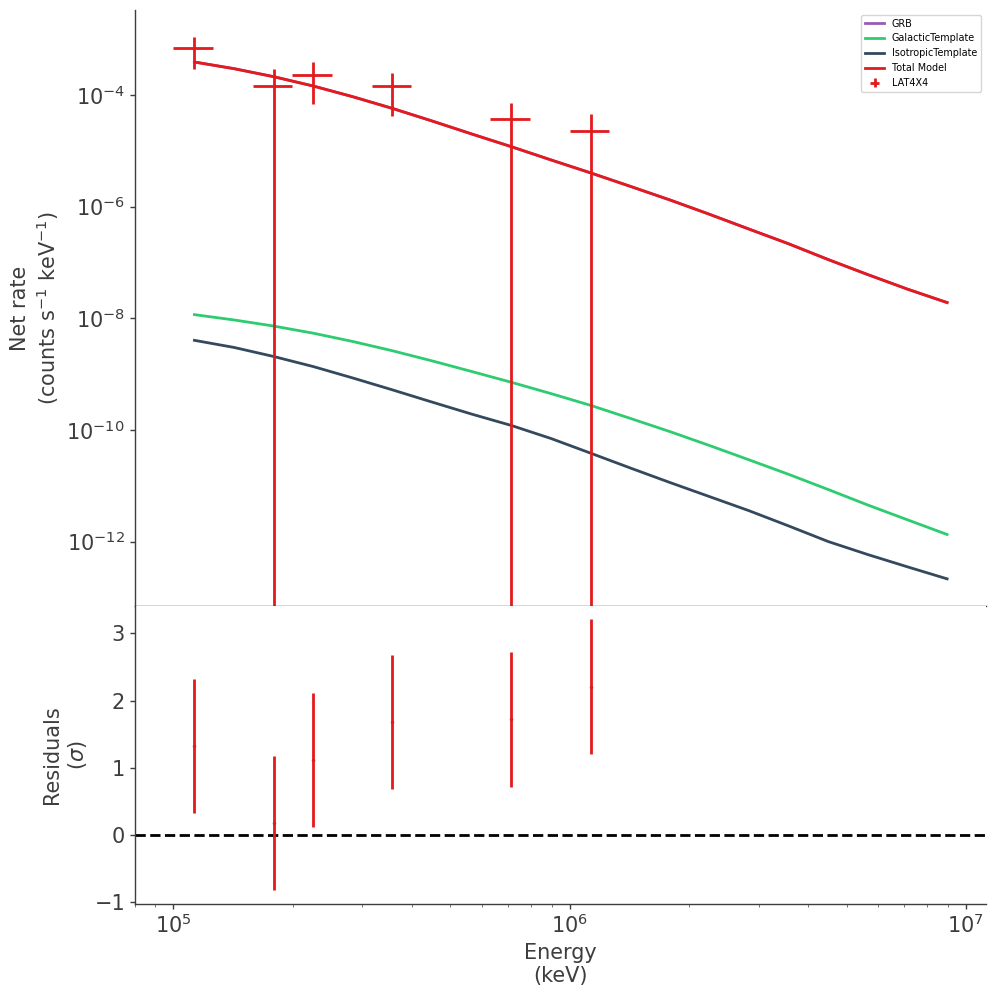

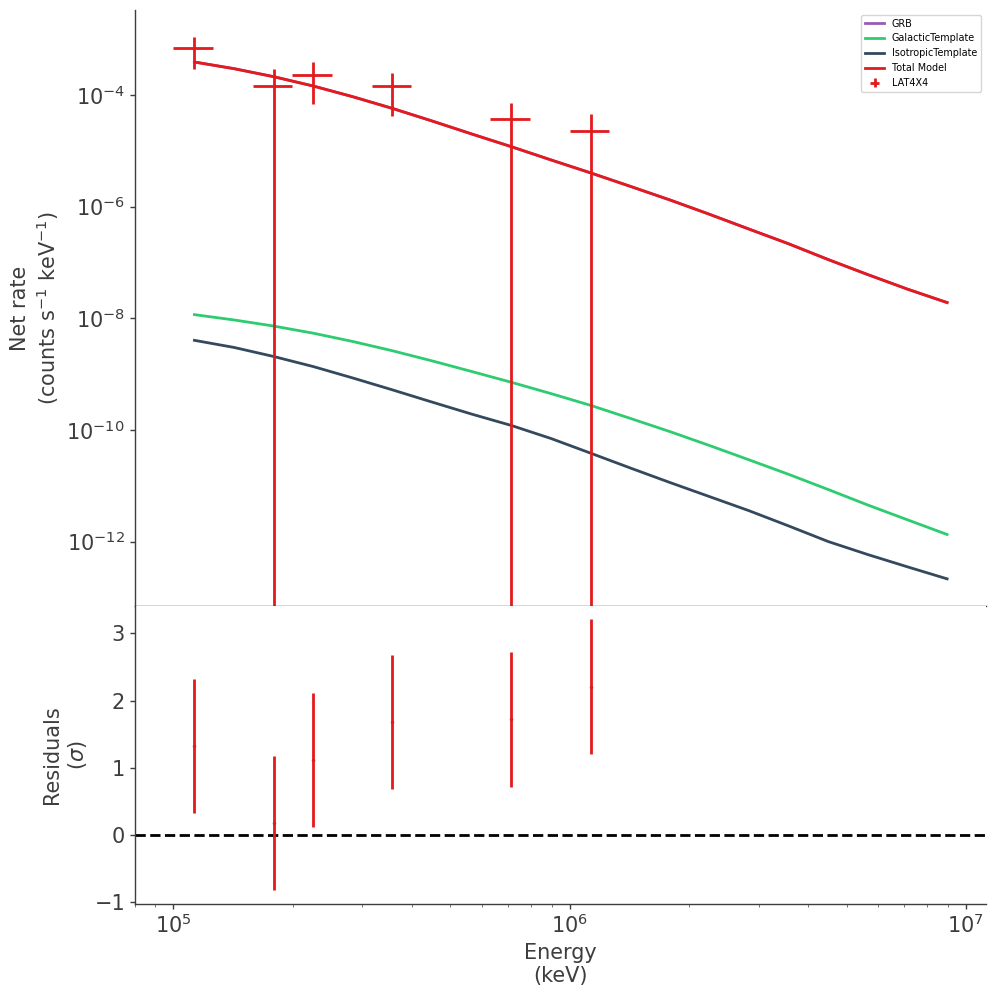

In [16]:
i = 3
T0, T1 = intervals[i], intervals[i + 1]
LAT_name = "LAT_%06.3f-%06.3f" % (T0, T1)
jl = results[LAT_name]
jl.results.display()
display_spectrum_model_counts(jl, step=False, figsize=(10, 10))

We can see the evolution of the spectrum with time (not all the bins are diplayed):


processing MLE analyses:   0%|          | 0/13 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

19:43:28 DEBUG     converting MeV to MeV                                                          ]8;id=164277;file:///Users/runner/work/threeML/threeML/threeML/io/plotting/model_plot.py\model_plot.py]8;;\:]8;id=337199;file:///Users/runner/work/threeML/threeML/threeML/io/plotting/model_plot.py#890\890]8;;\

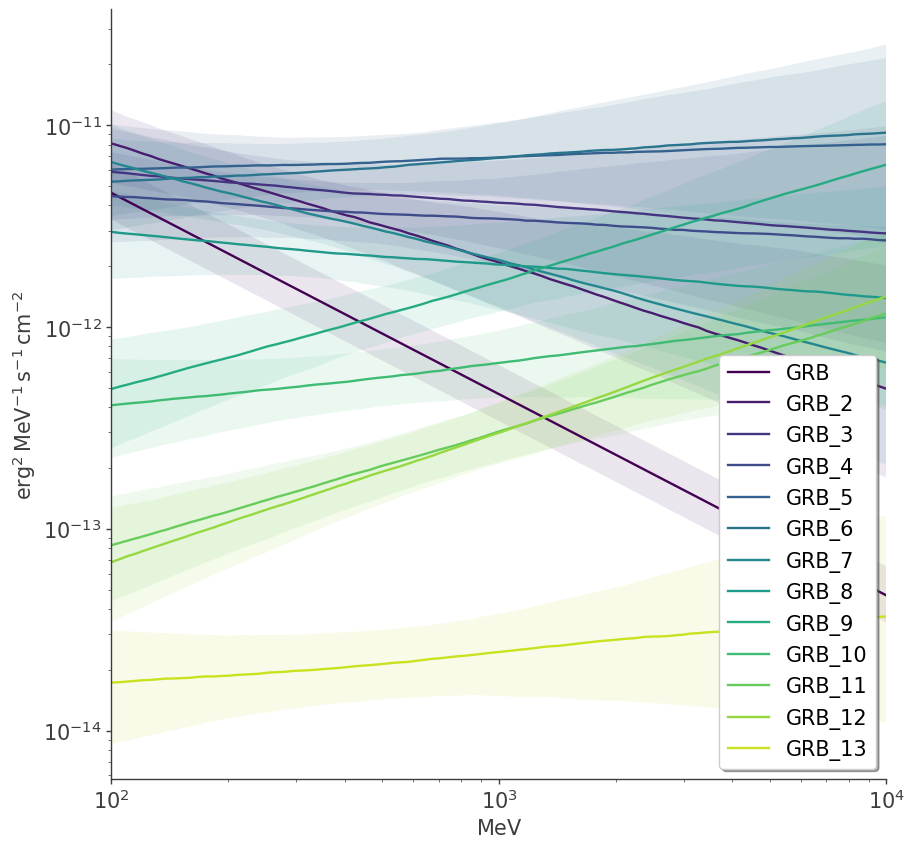

In [17]:
fig = plot_spectra(
    *[results[k].results for k in list(results.keys())[::2]],
    ene_min=100 * u.MeV,
    ene_max=10 * u.GeV,
    flux_unit="erg2/(cm2 s MeV)",
    energy_unit="MeV",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1)
)
fig.set_size_inches(10, 10)

Finally, we can display flux lightcurves and index evolution with time.


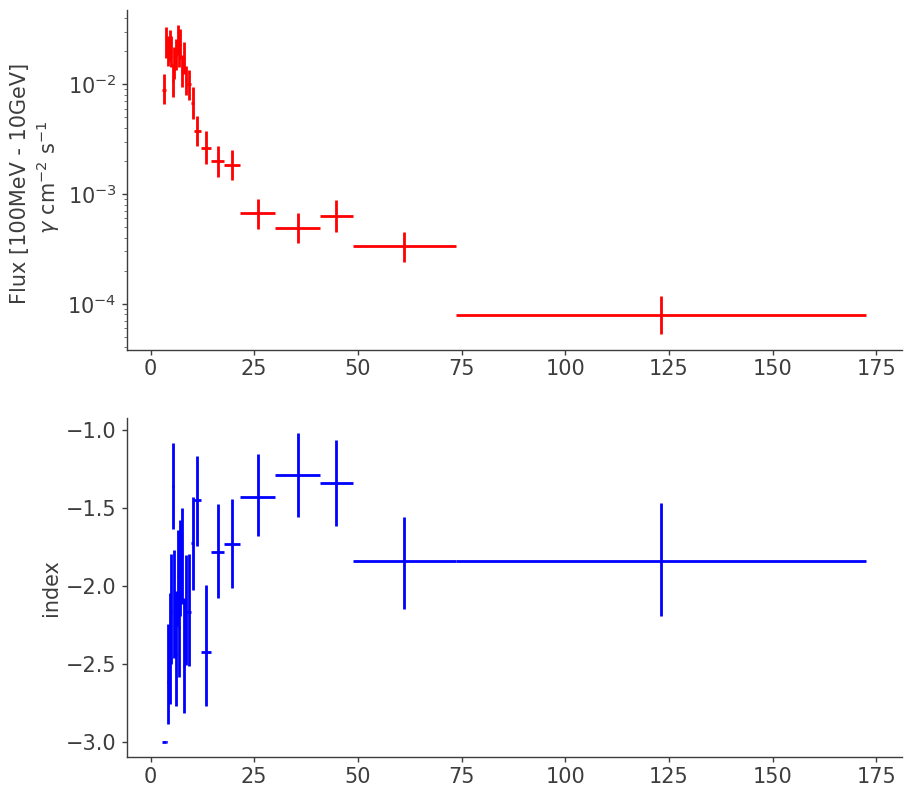

In [18]:
variates = ["F", "index"]
y = {}
for n in variates:
    y[n] = []
    y[n + "_p"] = []
    y[n + "_n"] = []
x = []
dx = []


for T0, T1 in zip(intervals[:-1], intervals[1:]):
    LAT_name = "LAT_%06.3f-%06.3f" % (T0, T1)
    x.append((T1 + T0) / 2)
    dx.append((T1 - T0) / 2)
    jl = results[LAT_name]
    res = jl.results
    mod = res.optimized_model
    ps = mod.point_sources

    for n in variates:
        my_variate = res.get_variates("GRB.spectrum.main.Powerlaw_flux.%s" % n)
        y[n].append(my_variate.median)
        y[n + "_p"].append(my_variate.equal_tail_interval()[1] - my_variate.median)
        y[n + "_n"].append(my_variate.median - my_variate.equal_tail_interval()[0])
        pass
    pass

fig = plt.figure(figsize=(10, 15))
colors = ["r", "b"]
ylabels = ["Flux [100MeV - 10GeV] \n $\gamma$ cm$^{-2}$ s$^{-1}$", "index"]
for i, n in enumerate(variates):
    plt.subplot(len(variates) + 1, 1, i + 1)
    plt.errorbar(x, y[n], xerr=dx, yerr=(y[n + "_n"], y[n + "_p"]), ls="", c=colors[i])
    if i == 0:
        plt.yscale("log")
    # plt.xscale('log')
    plt.ylabel(ylabels[i])
    pass